In [156]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import jax.numpy as jnp
import jax

In [129]:
# npzfile = np.load("/groups/funke/home/mehtay/research/MetaLearnPlasticity/expdata/sparse_inputs/student_coeffs.npz")
# student_coefficients = npzfile['arr_0']
# print("final student coefficients:\n", student_coefficients[-1])
student_coefficients = np.zeros((3,3,3))
student_coefficients[1][0][0] = 0.502
student_coefficients[0][0][1] = -0.258

teacher_coefficients = np.zeros((3,3,3))
teacher_coefficients[1][1][0] = 1
teacher_coefficients[0][2][1] = -1

In [165]:
n=5

key = jax.random.PRNGKey(0)
0.1 * jnp.multiply(jax.random.normal(key, (n,)), jnp.eye(n))

DeviceArray([[ 0.01878439, -0.        , -0.        ,  0.        ,
               0.        ],
             [ 0.        , -0.12833427, -0.        ,  0.        ,
               0.        ],
             [ 0.        , -0.        , -0.02710917,  0.        ,
               0.        ],
             [ 0.        , -0.        , -0.        ,  0.12490594,
               0.        ],
             [ 0.        , -0.        , -0.        ,  0.        ,
               0.024447  ]], dtype=float32)

In [160]:
key = jax.random.PRNGKey(0)
aa = jax.random.normal(key, (5,))
jnp.multiply(aa,jnp.eye(5))

DeviceArray([[ 0.18784384, -0.        , -0.        ,  0.        ,
               0.        ],
             [ 0.        , -1.2833426 , -0.        ,  0.        ,
               0.        ],
             [ 0.        , -0.        , -0.2710917 ,  0.        ,
               0.        ],
             [ 0.        , -0.        , -0.        ,  1.2490593 ,
               0.        ],
             [ 0.        , -0.        , -0.        ,  0.        ,
               0.24447003]], dtype=float32)

In [164]:
aa.shape

(5,)

In [158]:
jnp.count_nonzero(aa)

DeviceArray(5, dtype=int32)

In [128]:
data = pd.read_csv("/groups/funke/home/mehtay/research/MetaLearnPlasticity/expdata/sparse_inputs/expdf.csv")
data.head()

,Unnamed: 0,loss,r2_score,epoch
0,0,0.039480,0.015681,0
1,1,0.026797,0.165212,1
2,2,0.021867,0.282218,2
3,3,0.018581,0.379975,3
4,4,0.016075,0.462064,4


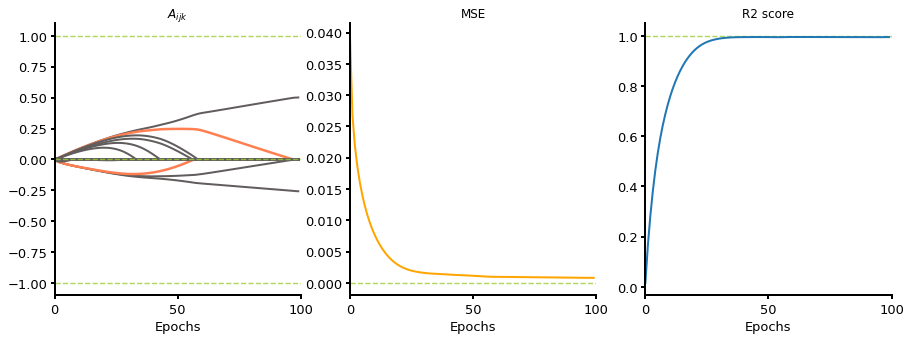

In [111]:
fontsize = 13
epochs = 100

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].axhline(y=1, color='yellowgreen', linestyle='--', linewidth=linewidth*0.7, alpha=0.8)
axes[0].axhline(y=-1, color='yellowgreen', linestyle='--', linewidth=linewidth*0.7, alpha=0.8)

for i in range(3):
    for j in range(3):
        for k in range(3):    
            col = '#625D5D'
            linewidth = 2
            if i == 1 and j == 1 and k == 0:
                # col = '#4863A0'
                col = 'coral'
                linewidth = 2.5
            elif i == 0 and j == 2 and k == 1:
                # col = '#fdb462'
                col = 'coral'
                linewidth = 2.5
            axes[0].plot([i for i in range(epochs)], student_coefficients[:epochs,i,j,k],color = col, linewidth = linewidth)
            
# ax.set_ylabel(r'$A$', fontname="arial", fontsize=fontsize , labelpad = 6)
ax = axes[0]
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.tick_params(width=linewidth, labelsize=fontsize, length=2*linewidth)
    ax.set_xticks([0,int(epochs/2), epochs])
    ax.set_xlabel('Epochs', fontsize=fontsize)
    ax.set_xlim([0,epochs])

axes[0].axhline(y=0, color='yellowgreen', linestyle='--', linewidth=linewidth*0.7, alpha=0.8)
axes[0].set_title("$A_{ijk}$")
axes[1].axhline(y=0, color='yellowgreen', linestyle='--', linewidth=linewidth*0.7, alpha=0.8)
axes[1].set_title("MSE")
axes[2].axhline(y=1, color='yellowgreen', linestyle='--', linewidth=linewidth*0.7, alpha=0.8)
axes[2].set_title("R2 score")

axes[1].plot([i for i in range(epochs)], data["loss"][:epochs], color='orange', linewidth = linewidth)
axes[2].plot([i for i in range(epochs)], data["r2_score"][:epochs], linewidth = linewidth)

# plt.show()
plt.savefig('imgs/ojaexps/Aijk.png', dpi=500, bbox_inches="tight")

In [130]:
def volterra_synapse_tensor(pre, post, weight):
    synapse_tensor = jnp.outer(
        jnp.outer(
            jnp.array([pre**0, pre**1, pre**2]),
            jnp.array([post**0, post**1, post**2]),
        ),
        jnp.array([weight**0, weight**1, weight**2]),
    )

    synapse_tensor = jnp.reshape(synapse_tensor, (3, 3, 3))
    return synapse_tensor


def volterra_plasticity_function(pre, post, weight, volterra_coefficients):

    synapse_tensor = volterra_synapse_tensor(pre, post, weight)
    dw = jnp.sum(jnp.multiply(volterra_coefficients, synapse_tensor))
    return dw

In [136]:
w=0.1
diff_tensor = np.zeros((3,20,20))
x = np.arange(0.2, 0.4, 0.01)
y = np.arange(0.4, 0.6, 0.01)

x_grid, y_grid = np.meshgrid(x,y,indexing="ij")
epochs_snapshot = [0, 15, 100]

# for index, epoch in enumerate(epochs_snapshot):
#     for i in range(20):
#         for j in range(20):
#             diff_tensor[index][i][j] = abs(volterra_plasticity_function(x_grid[i][j],y_grid[i][j],w,teacher_coefficients) - volterra_plasticity_function(x_grid[i][j],y_grid[i][j],w,student_coefficients[epoch]))

for index, epoch in enumerate(epochs_snapshot):
    for i in range(20):
        for j in range(20):
            diff_tensor[index][i][j] = abs(volterra_plasticity_function(x_grid[i][j],y_grid[i][j],w,teacher_coefficients) - volterra_plasticity_function(x_grid[i][j],y_grid[i][j],w,student_coefficients))

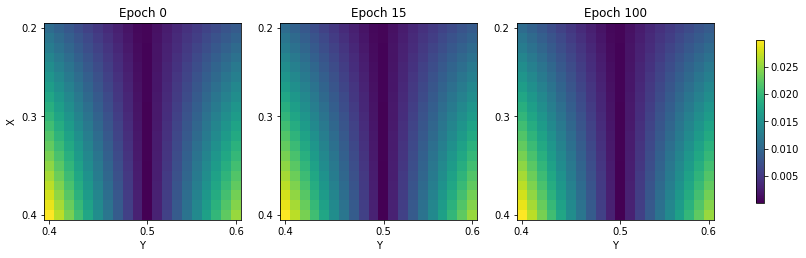

In [141]:
vmin = np.min(diff_tensor)
vmax = np.max(diff_tensor)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap='viridis'

for epoch, ax, data in zip(epochs_snapshot, axes, list(diff_tensor)):
    im = ax.imshow(data, cmap=cmap, norm=norm, aspect=1)
    ax.set_title("Epoch {}".format(epoch))
    ax.set_yticks(ticks=[0, 9, 19], labels=[0.2, 0.3, 0.4])
    ax.set_xticks(ticks=[0, 10, 19], labels=[0.4, 0.5, 0.6])
    ax.set_xlabel("Y")

axes[0].set_ylabel("X")
# fig.subplots_adjust(right=0.8)
fig.colorbar(im, ax=axes[:], shrink=0.6)

# plt.show()
plt.savefig('imgs/ojaexps/diff_tensor', dpi=500)

In [140]:
y_grid[:,10]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [149]:
aa = np.ones((3,4))
np.min(aa)

1.0

In [88]:
for i in range(20):
    for j in range(20):
        dw_matrix[i][j] = volterra_plasticity_function(x_grid[i][j],y_grid[i][j],w,student_coefficients[-1]) - volterra_plasticity_function(x_grid[i][j],y_grid[i][j],w,teacher_coefficients)

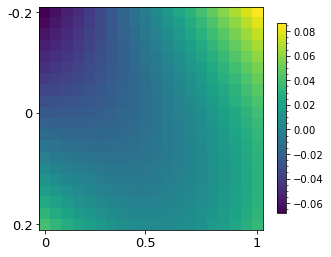

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))
pos = ax.imshow(dw_matrix)
plt.xticks(ticks=[0, 9, 19], labels=[0, 0.5, 1], fontsize=13, fontname='Arial')
plt.yticks(ticks=[0, 9, 19], labels=[-0.2, 0, 0.2], fontsize=13, fontname='Arial')

# ax.xaxis.tick_top()
cbar = fig.colorbar(pos, ax=ax, shrink=0.7)
# cbar = fig.colorbar(pos, ax=ax, anchor=(0, 0.3), shrink=0.7, ticks=[0.5, 1])
# cbar = fig.colorbar(pos, ax=ax, shrink=0.7, ticks=[0, 0.001, 0.002, 0.003, 0.004, 0.005])
# cbar.ax.set_yticklabels(['0', '1e-3', '2e-3', '3e-3', '4e-3', '5e-3'])
cbar.minorticks_on()

plt.show()

In [51]:
volterra_plasticity_function(-0.2,1,-0.1,teacher_coefficients)

DeviceArray(-0.1, dtype=float32)

In [52]:
volterra_plasticity_function(-0.2,1,0.1,teacher_coefficients)

DeviceArray(-0.3, dtype=float32)

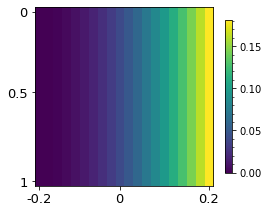

In [50]:
fig, ax = plt.subplots(figsize=(4, 4))
pos = ax.imshow(dw_matrix)
plt.xticks(ticks=[0, 9, 19], labels=[-0.2, 0, 0.2], fontsize=13, fontname='Arial')
plt.yticks(ticks=[0, 9, 19], labels=[0, 0.5, 1], fontsize=13, fontname='Arial')

# ax.xaxis.tick_top()
cbar = fig.colorbar(pos, ax=ax, shrink=0.7)
# cbar = fig.colorbar(pos, ax=ax, anchor=(0, 0.3), shrink=0.7, ticks=[0.5, 1])
# cbar = fig.colorbar(pos, ax=ax, shrink=0.7, ticks=[0, 0.001, 0.002, 0.003, 0.004, 0.005])
# cbar.ax.set_yticklabels(['0', '1e-3', '2e-3', '3e-3', '4e-3', '5e-3'])
cbar.minorticks_on()

plt.show()